# First Draft For Descriptive Statistics of the Dataset

## Some basic Data import

In [1]:
#Importing our Packages: Analytics
import pandas as pd
import numpy as np

#Viz libaries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

#Data_libraries
import pymysql
import sqlalchemy


#Sklearn libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso

#Scoring libraries
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import r2_score

In [2]:
#Create String for data creation
querystring = """SELECT dwu.code_commune AS code,
dwu.type_local AS type,  
year(dwu.date_mutation) AS 'Year', 
dwu.nom_commune AS commune,
dwu.code_postal AS Code_post,
ROUND(AVG(dwu.valeur_fonciere/dwu.surface_reelle_bati),0) AS Prixm2,
ROUND(AVG(dwu.valeur_fonciere),0) AS Price,
ROUND(AVG(dwu.surface_reelle_bati),0) AS Avg_sqm,
COUNT(dwu.id_mutation) AS transactions,
MAX(dwu.latitude) AS lat,
MAX(dwu.longitude) AS lon
FROM data_working_update dwu
WHERE dwu.type_local IN('Appartement', 'Maison')
GROUP BY code_commune, nom_commune,dwu.code_postal, dwu.type_local, year(dwu.date_mutation);
"""

In [3]:
#Load Libraries and Create engine Connection

engine =sqlalchemy.create_engine(
        sqlalchemy.engine.url.URL.create(
        drivername="mysql+pymysql",
        username='Estimators',  # e.g. "my-database-user"
        password='Estimator2021',  # e.g. "my-database-password"
        host='34.77.88.127',  # e.g. "127.0.0.1"
        port=3306,  # e.g. 3306
        database='Housing_France',  # e.g. "my-database-name"
    ))

conn = engine.connect().execution_options(stream_results=True)    

def get_data(querystring,chunk):
    engine =sqlalchemy.create_engine(
    sqlalchemy.engine.url.URL.create(
    drivername="mysql+pymysql",
    username='Estimators',  # e.g. "my-database-user"
    password='Estimator2021',  # e.g. "my-database-password"
    host='34.77.88.127',  # e.g. "127.0.0.1"
    port=3306,  # e.g. 3306
    database='Housing_France',  # e.g. "my-database-name"
    ))
    conn = engine.connect().execution_options(stream_results=True)
    frame = pd.DataFrame()
    for chunk_dataframe in pd.read_sql(
            querystring, conn, chunksize=chunk):
            #print(f"Got dataframe w/{len(chunk_dataframe)} rows")
            frame= frame.append(chunk_dataframe)

            # ... do something with dataframe ...
            
    return frame

,code,Year,Code_post,Prixm2,Price,Avg_sqm,transactions,lat,lon
code,1.000000,0.011524,0.995112,0.075484,0.084333,-0.002490,0.058096,0.059599,-0.054278
Year,0.011524,1.000000,0.010642,0.020478,0.034592,0.013901,-0.000144,0.023972,-0.004505
Code_post,0.995112,0.010642,1.000000,0.077504,0.085938,-0.007534,0.057543,0.057124,-0.045134
Prixm2,0.075484,0.020478,0.077504,1.000000,0.795801,-0.189001,0.191009,-0.036689,0.031881
Price,0.084333,0.034592,0.085938,0.795801,1.000000,0.177759,0.145737,-0.031405,0.046748
Avg_sqm,-0.002490,0.013901,-0.007534,-0.189001,0.177759,1.000000,-0.100783,0.019598,-0.007236
transactions,0.058096,-0.000144,0.057543,0.191009,0.145737,-0.100783,1.000000,0.010670,0.000027
lat,0.059599,0.023972,0.057124,-0.036689,-0.031405,0.019598,0.010670,1.000000,0.032731
lon,-0.054278,-0.004505,-0.045134,0.031881,0.046748,-0.007236,0.000027,0.032731,1.000000


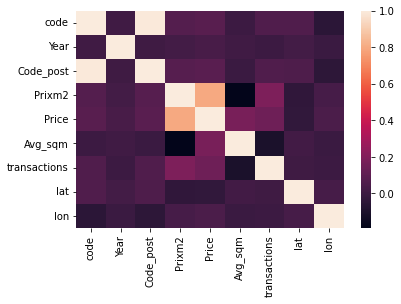

In [4]:
#Get data from Mysql on Gcloud
df = get_data(querystring, 100000)
df.head(10)

#Get the correlations
corr =df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
corr

## Basic Filtering of data to remove outliers

In [5]:
df2 = df[df.Prixm2.between(500,10000)]
df2.Prixm2 = np.log(df2.Prixm2)
df2.Price = np.log(df2.Price)
df2.head(5)

/home/julienlefebvre/.pyenv/versions/3.8.6/envs/Housing/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,code,type,Year,commune,Code_post,Prixm2,Price,Avg_sqm,transactions,lat,lon
0,1370,Appartement,2016,Saint-Laurent-sur-Saône,1750,7.478735,11.465802,63.0,37,46.309896,4.843260
1,1364,Maison,2016,Saint-Jean-sur-Reyssouze,1560,7.148346,11.856260,118.0,18,46.422331,5.086478
2,1050,Maison,2016,Boissey,1190,7.639642,12.224404,98.0,2,46.383446,4.996678
3,1024,Maison,2016,Attignat,1340,7.428333,12.164917,119.0,50,46.296672,5.195046
4,1130,Maison,2016,Bresse Vallons,1340,7.502186,12.176999,112.0,33,46.335343,5.216090


## Initial Visualizations and Description


<AxesSubplot:xlabel='Prixm2', ylabel='Count'>

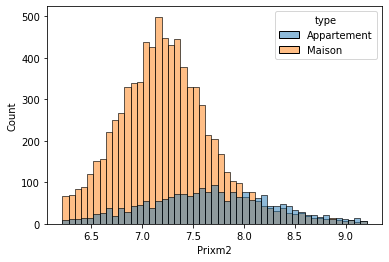

In [6]:
sns.histplot(data= df2.iloc[:10000,:], x='Prixm2', hue='type')

## Some nicely distributed violins year over year: no anomalities in the timeseries dimension

- Prices seem to be normally distributed throughout time
- Appartment curve confirmed to be flat over time
-  

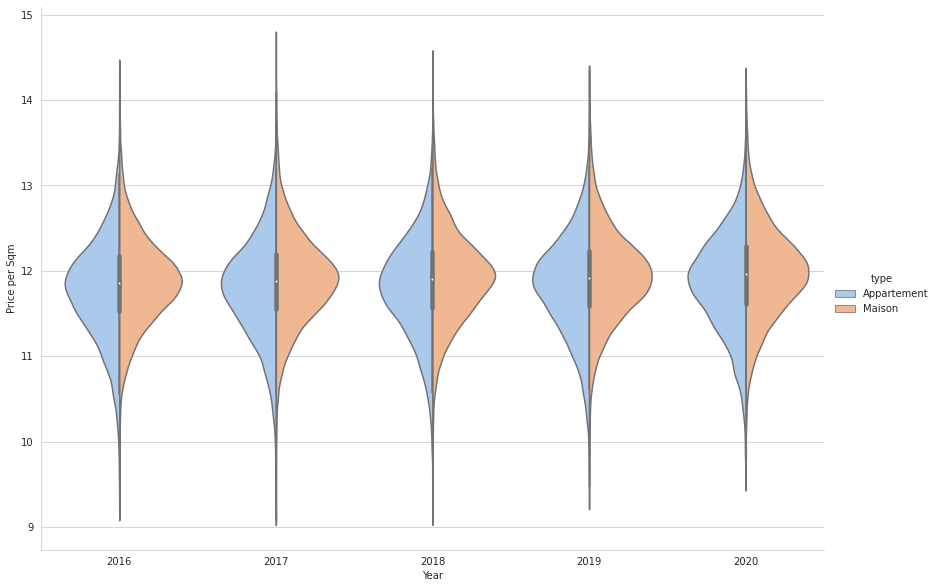

In [7]:
sns.set_style('whitegrid')
colors = ["#FFF19E", ]
g = sns.catplot(x='Year',y ='Price', 
                hue ='type',
                #order=["2016", "2017", "2018", "2019","2020"],
                data = df2, kind= "violin", 
                palette="pastel", 
                split=True, height=8.27, aspect=11.7/8.27)
g.set_ylabels("Price per Sqm")
#g.set(ylim=(0, 10000))

Text(0.5, 1.0, 'Evolution prix')

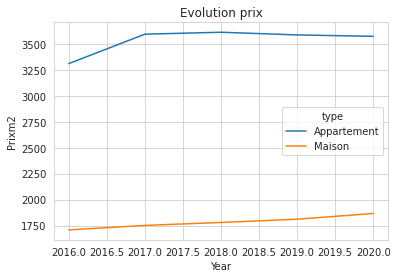

In [8]:
#Aha, app prices seem to stagnate while housing prices display a continuous increase
df3 = df.groupby(['Year','type']).mean()['Prixm2']
df3 =df3.reset_index(drop =False)
sns.lineplot(data= df3, x='Year',y='Prixm2', hue='type')
plt.title('Evolution prix')

Price Evolution seems to be:
- more or less stable for appartments with a small declining trend
- increasing slowly for Houses

In [9]:
#Basic Statistics
df2.describe()

,code,Year,Code_post,Prixm2,Price,Avg_sqm,transactions,lat,lon
count,191919.000000,191919.000000,191919.000000,191919.000000,191919.000000,191919.000000,191919.000000,191919.000000,191919.000000
mean,46195.654776,2017.984254,46467.561159,7.443846,11.896482,96.012344,25.479692,46.113530,2.488366
std,26420.967310,1.399172,26190.610336,0.545979,0.544820,31.708565,89.148444,6.013114,4.674639
min,2.000000,2016.000000,0.000000,6.214608,9.210340,10.000000,1.000000,-21.353068,-63.015466
25%,25147.000000,2017.000000,25210.000000,7.075809,11.564882,76.000000,3.000000,44.839872,0.572106
50%,45278.000000,2018.000000,45480.000000,7.393263,11.902850,97.000000,8.000000,46.928197,2.515857
75%,69183.000000,2019.000000,69490.000000,7.768533,12.225569,112.000000,20.000000,48.671869,4.627094
max,97424.000000,2020.000000,97490.000000,9.210340,14.667235,1018.000000,5215.000000,51.082118,55.827382


# Let's Get More Serious

In [10]:
#Get the initial data
df = pd.read_csv('DataFrance/equipment_Geo.csv', sep=';')
df.dropna(subset=['UU2020'], inplace=True)

/home/julienlefebvre/.pyenv/versions/3.8.6/envs/Housing/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,2,4,5,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Get the dataframe into shape

In [11]:
# Select columns that will be interesting to us
df6 = df[['DEPCOM', 'TYPEQU','DEP']]
liste= ("A203","A206","A401","A101","A406","A405", "A5", "B", "F")
df6 = df6[df6.TYPEQU.str.startswith(liste)]
df6.shape

#Pivot raw data into a more sense making dataframe
df6 =df6.pivot_table(values='TYPEQU', index='DEPCOM',columns= 'TYPEQU',aggfunc='count').reset_index(drop=False)
df6 = df6.fillna(0)
df6.head()

TYPEQU,DEPCOM,A101,A203,A206,A401,A405,A406,A501,A502,A503,...,F201,F202,F203,F303,F305,F306,F307,F308,F309,F310
0,1004,0.0,12.0,2.0,25.0,16.0,9.0,24.0,2.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1008,0.0,0.0,0.0,2.0,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1014,0.0,0.0,0.0,8.0,2.0,0.0,6.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1024,0.0,1.0,0.0,3.0,5.0,2.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1025,0.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [12]:
#Rename Columns with the respective columns only
categories = set(["A2","A4","A1", "A5", "B", "F"])

def correct_categories(cols):
    return [cat for col in cols for cat in categories if col.startswith(cat)]    

names = correct_categories(df6.columns)
names.insert(0,'DEPCOM')
df6.columns = names

#Format and Sun up  of features into their categories
df7 = df6.drop(columns='DEPCOM').astype('int')
df7 =df7.groupby(df7.columns, axis=1).agg(np.sum)
df7.insert(0,'DEPCOM',df6.DEPCOM)
df7.shape

#Merge the two dataframes
merged = df7.merge(df2[['Prixm2','code','type','commune']], left_on='DEPCOM', right_on='code' ,how='inner').drop(columns='code')
merged.head()

,DEPCOM,A1,A2,A4,A5,B,F,Prixm2,type,commune
0,1004,0,14,50,126,138,31,7.714677,Maison,Ambérieu-en-Bugey
1,1004,0,14,50,126,138,31,7.929846,Appartement,Ambérieu-en-Bugey
2,1004,0,14,50,126,138,31,7.859027,Appartement,Ambérieu-en-Bugey
3,1004,0,14,50,126,138,31,7.575072,Maison,Ambérieu-en-Bugey
4,1004,0,14,50,126,138,31,7.661056,Maison,Ambérieu-en-Bugey


## One hot encode communes and appartment types

In [13]:
from sklearn.preprocessing import LabelBinarizer
merged.type = LabelBinarizer().fit_transform(merged.type)
df8 = pd.get_dummies(merged.commune, prefix='comm')

#Getting the final frame with encoded values
final = merged.drop(columns=['commune','DEPCOM']).join(df8)

## Create our prediction Arrays and format (PCA / Scaler)

In [32]:
X = final.drop(columns='Prixm2')
y = final.Prixm2

#Scale the data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)


In [33]:
#Performing normal train test split on the formatted data (both X and target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)



### Optional: PCA for treatment - bad results so far

In [15]:
# Defining our PCA model and converting our data into components
#pca_model = PCA(n_components=5)
#converted = pca_model.fit(X)
#X = converted.transform(X)
#X = X.drop(columns=X.columns[:6]).join(pd.DataFrame(X_scale, columns=X.columns[:6]))


# Do the Prediction Model

- Linear Model first
- Set of linear models second
- Xgboost
- Other advanced Techniques

## Fit and Predict models

In [35]:
#Do the first basic model
lr = LinearRegression()
model = lr.fit(X_train, y_train)
print(f"{model} R2 score is: {np.round(model.score(X_test, y_test),3)})")
print(f"{model} rmse score is: {np.round(rmse(model.predict(X_test),y_test),3)})")
print(f"{model} mape score is: {np.round(mape(model.predict(X_test),y_test),3)}"  )  

LinearRegression() R2 score is: -1.830514029245583e+16)
LinearRegression() rmse score is: 5082426718849469.0)
LinearRegression() mape score is: 0.036


In [ ]:
#Checking a variety of linear models
models = [la,ri,lr]
for model in models:
    fitter = model.fit(X_train,y_train)
    print(f"{model} R2 score is: {np.round(model.score(X_test, y_test),3)})")
    print(f"{model} rmse score is: {np.round(rmse(model.predict(X_test),y_test),3)})")
    print(f"{model} mape score is: {np.round(mape(model.predict(X_test),y_test),3)}"  )   

In [ ]:
#Checking the result with a standard xgboost
from xgboost import XGBRegressor as xgb
model = xgb(learning_rate = .1)
model = model.fit(X_train, y_train)
fitter = model.fit(X_train,y_train)
print(f" R2 score is: {np.round(model.score(X_test, y_test),3)})")
print(f"rmse score is: {np.round(rmse(model.predict(X_test),y_test),3)})")
print(f" mape score is: {np.round(mape(model.predict(X_test),y_test),3)}"  )  

## Check against initial baseline model
- Average price a a predictor

In [ ]:
#Obtain Baseline Model
dftest = pd.DataFrame(final['Prixm2'])
dftest['baseline'] = dftest['Prixm2'].mean()
dftest.head()

In [ ]:
#print baseline Score Metrics
print(r2_score(dftest.Prixm2, dftest.baseline))
print(mean_squared_error(dftest.Prixm2, dftest.baseline))
print(mape(dftest.Prixm2, dftest.baseline))